project_name = 'wgan_face_generation'

In [ ]:
## WGAN modified of DCGAN in:
1. remove sigmoid in the last layer of discriminator(classification -> regression)                                    
2. no log Loss (Wasserstein distance)

3. clip param norm to c (Wasserstein distance and Lipschitz continuity)

4. No momentum-based optimizer, use RMSProp，SGD instead

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lawrence880301
Your Kaggle Key: ··········


  1%|          | 5.00M/441M [00:00<00:13, 34.3MB/s]

100%|██████████| 441M/441M [00:06<00:00, 76.3MB/s]


In [ ]:
!pip install opendatasets --upgrade --quiet

import opendatasets as od

dataset_url = 'https://www.kaggle.com/soumikrakshit/anime-faces'
od.download(dataset_url)


['data']


In [ ]:
import os

DATA_DIR = './anime-faces'
print(os.listdir(DATA_DIR))

['2891.png', '6905.png', '17.png', '11743.png', '3157.png', '8961.png', '6313.png', '6887.png', '3383.png', '10114.png']


print(os.listdir(DATA_DIR+'/data')[:10])

In [ ]:
Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

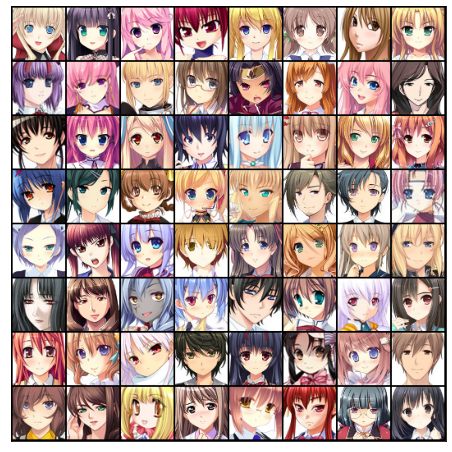

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [ ]:
## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

device(type='cuda')

device = get_default_device()
device

In [ ]:
We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [ ]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    # Modification 1: remove sigmoid
    # nn.Sigmoid()

    )

In [ ]:
Note that we're using the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

Let's move the discriminator model to the chosen device.

discriminator = to_device(discriminator, device)

In [ ]:
## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [ ]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [ ]:
We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

In [ ]:
def weight_init(m):
    # weight_initialization: important for wgan
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:
        m.weight.data.normal_(0,0.02)
    elif class_name.find('Norm')!=-1:
        m.weight.data.normal_(1.0,0.02)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

torch.Size([128, 3, 64, 64])


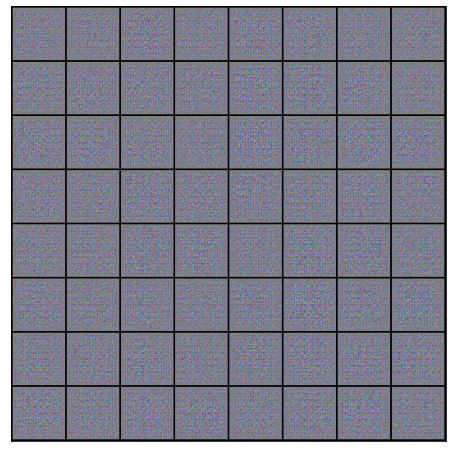

In [ ]:
discriminator.apply(weight_init)
generator.apply(weight_init)

xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
As one might expect, the output from the generator is basically random noise, since we haven't trained it yet. 

Let's move the generator to the chosen device.

generator = to_device(generator, device)

In [ ]:
## Discriminator Training



def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    #modification: remove binary cross entropy
        #real_targets = torch.ones(real_images.size(0), 1, device=device)
        #real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_loss = -torch.mean(real_preds)
        
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    #modification: remove binary cross entropy
        #fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
        #fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_loss = torch.mean(fake_preds)

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_loss.item(), fake_loss.item()

In [ ]:
## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.


- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    #modificationL remove binary cross entropy
        #targets = torch.ones(batch_size, 1, device=device)
    loss = -torch.mean(preds)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


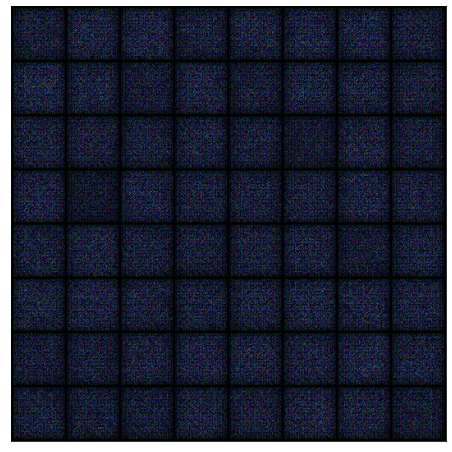

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

save_samples(0, fixed_latent)

In [ ]:
## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.




In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
    opt_g = torch.optim.RMSprop(generator.parameters(), lr=lr)
    
    
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # modification: clip param for discriminator
            for parm in discriminator.parameters():
                parm.data.clamp_(-clamp_num, clamp_num)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [ ]:
lr = 0.00005
epochs = 100
clamp_num=0.01# WGAN clip gradient


Epoch [1/100], loss_g: 0.5336, loss_d: -0.8061, real_score: -0.5219, fake_score: -0.2842
Saving generated-images-0001.png



Epoch [2/100], loss_g: 0.4352, loss_d: -0.8460, real_score: -0.2781, fake_score: -0.5679
Saving generated-images-0002.png



Epoch [3/100], loss_g: 0.5736, loss_d: -0.7685, real_score: -0.5053, fake_score: -0.2632
Saving generated-images-0003.png



Epoch [4/100], loss_g: 0.4401, loss_d: -0.8334, real_score: -0.3105, fake_score: -0.5229
Saving generated-images-0004.png



Epoch [5/100], loss_g: 0.3152, loss_d: -0.7761, real_score: -0.2377, fake_score: -0.5384
Saving generated-images-0005.png



Epoch [6/100], loss_g: 0.3373, loss_d: -0.7422, real_score: -0.2378, fake_score: -0.5044
Saving generated-images-0006.png



Epoch [7/100], loss_g: 0.3334, loss_d: -0.7895, real_score: -0.2532, fake_score: -0.5362
Saving generated-images-0007.png



Epoch [8/100], loss_g: 0.4959, loss_d: -0.5961, real_score: -0.4924, fake_score: -0.1037
Saving generated-images-0008.png



Epoch [9/100], loss_g: 0.2151, loss_d: -0.6630, real_score: -0.1576, fake_score: -0.5055
Saving generated-images-0009.png



Epoch [10/100], loss_g: 0.2668, loss_d: -0.7297, real_score: -0.2194, fake_score: -0.5103
Saving generated-images-0010.png



Epoch [11/100], loss_g: 0.4800, loss_d: -0.6063, real_score: -0.4498, fake_score: -0.1565
Saving generated-images-0011.png



Epoch [12/100], loss_g: 0.1030, loss_d: -0.5274, real_score: -0.0329, fake_score: -0.4945
Saving generated-images-0012.png



Epoch [13/100], loss_g: 0.4851, loss_d: -0.5649, real_score: -0.4195, fake_score: -0.1454
Saving generated-images-0013.png



Epoch [14/100], loss_g: 0.1352, loss_d: -0.5524, real_score: -0.1075, fake_score: -0.4448
Saving generated-images-0014.png



Epoch [15/100], loss_g: 0.4699, loss_d: -0.5101, real_score: -0.4093, fake_score: -0.1007
Saving generated-images-0015.png



Epoch [16/100], loss_g: 0.1468, loss_d: -0.4826, real_score: -0.0625, fake_score: -0.4201
Saving generated-images-0016.png



Epoch [17/100], loss_g: 0.4290, loss_d: -0.4664, real_score: -0.4231, fake_score: -0.0432
Saving generated-images-0017.png



Epoch [18/100], loss_g: 0.0806, loss_d: -0.4615, real_score: -0.0452, fake_score: -0.4162
Saving generated-images-0018.png



Epoch [19/100], loss_g: 0.4468, loss_d: -0.4616, real_score: -0.4283, fake_score: -0.0333
Saving generated-images-0019.png



Epoch [20/100], loss_g: 0.0727, loss_d: -0.4743, real_score: -0.0656, fake_score: -0.4088
Saving generated-images-0020.png



Epoch [21/100], loss_g: 0.4264, loss_d: -0.4452, real_score: -0.3976, fake_score: -0.0476
Saving generated-images-0021.png



Epoch [22/100], loss_g: 0.0899, loss_d: -0.4108, real_score: -0.0030, fake_score: -0.4078
Saving generated-images-0022.png



Epoch [23/100], loss_g: 0.4326, loss_d: -0.4500, real_score: -0.3940, fake_score: -0.0560
Saving generated-images-0023.png



Epoch [24/100], loss_g: 0.0205, loss_d: -0.4218, real_score: 0.0057, fake_score: -0.4276
Saving generated-images-0024.png



Epoch [25/100], loss_g: 0.4179, loss_d: -0.3762, real_score: -0.3969, fake_score: 0.0207
Saving generated-images-0025.png



Epoch [26/100], loss_g: 0.0711, loss_d: -0.4061, real_score: 0.0052, fake_score: -0.4114
Saving generated-images-0026.png



Epoch [27/100], loss_g: 0.4033, loss_d: -0.4039, real_score: -0.3602, fake_score: -0.0437
Saving generated-images-0027.png



Epoch [28/100], loss_g: 0.0342, loss_d: -0.4164, real_score: -0.0268, fake_score: -0.3896
Saving generated-images-0028.png



Epoch [29/100], loss_g: 0.3986, loss_d: -0.3662, real_score: -0.3801, fake_score: 0.0139
Saving generated-images-0029.png



Epoch [30/100], loss_g: 0.0492, loss_d: -0.3820, real_score: 0.0222, fake_score: -0.4042
Saving generated-images-0030.png



Epoch [31/100], loss_g: 0.3752, loss_d: -0.4215, real_score: -0.3329, fake_score: -0.0886
Saving generated-images-0031.png



Epoch [32/100], loss_g: -0.0661, loss_d: -0.4051, real_score: -0.0341, fake_score: -0.3711
Saving generated-images-0032.png



Epoch [33/100], loss_g: 0.4219, loss_d: -0.3508, real_score: -0.3601, fake_score: 0.0093
Saving generated-images-0033.png



Epoch [34/100], loss_g: 0.0960, loss_d: -0.3933, real_score: -0.0488, fake_score: -0.3445
Saving generated-images-0034.png



Epoch [35/100], loss_g: 0.4166, loss_d: -0.3734, real_score: -0.3946, fake_score: 0.0212
Saving generated-images-0035.png



Epoch [36/100], loss_g: 0.0866, loss_d: -0.3830, real_score: -0.0722, fake_score: -0.3108
Saving generated-images-0036.png



Epoch [37/100], loss_g: 0.3712, loss_d: -0.3702, real_score: -0.3323, fake_score: -0.0379
Saving generated-images-0037.png



Epoch [38/100], loss_g: 0.0294, loss_d: -0.3414, real_score: 0.0042, fake_score: -0.3456
Saving generated-images-0038.png



Epoch [39/100], loss_g: 0.4087, loss_d: -0.3708, real_score: -0.3408, fake_score: -0.0299
Saving generated-images-0039.png



Epoch [40/100], loss_g: 0.0311, loss_d: -0.3679, real_score: -0.0111, fake_score: -0.3568
Saving generated-images-0040.png



Epoch [41/100], loss_g: 0.3857, loss_d: -0.3439, real_score: -0.3112, fake_score: -0.0327
Saving generated-images-0041.png



Epoch [42/100], loss_g: -0.0074, loss_d: -0.3607, real_score: 0.0091, fake_score: -0.3698
Saving generated-images-0042.png



Epoch [43/100], loss_g: 0.3737, loss_d: -0.3360, real_score: -0.3568, fake_score: 0.0208
Saving generated-images-0043.png



Epoch [44/100], loss_g: -0.0017, loss_d: -0.3314, real_score: 0.0135, fake_score: -0.3449
Saving generated-images-0044.png



Epoch [45/100], loss_g: 0.3617, loss_d: -0.3361, real_score: -0.3072, fake_score: -0.0289
Saving generated-images-0045.png



Epoch [46/100], loss_g: 0.0113, loss_d: -0.3003, real_score: 0.0605, fake_score: -0.3607
Saving generated-images-0046.png



Epoch [47/100], loss_g: 0.3811, loss_d: -0.3109, real_score: -0.3462, fake_score: 0.0353
Saving generated-images-0047.png



Epoch [48/100], loss_g: 0.0562, loss_d: -0.3589, real_score: -0.0496, fake_score: -0.3093
Saving generated-images-0048.png



Epoch [49/100], loss_g: 0.3504, loss_d: -0.2598, real_score: -0.3589, fake_score: 0.0992
Saving generated-images-0049.png



Epoch [50/100], loss_g: -0.0695, loss_d: -0.3380, real_score: 0.0047, fake_score: -0.3427
Saving generated-images-0050.png



Epoch [51/100], loss_g: 0.3106, loss_d: -0.3267, real_score: -0.2708, fake_score: -0.0559
Saving generated-images-0051.png



Epoch [52/100], loss_g: 0.0183, loss_d: -0.3321, real_score: -0.0019, fake_score: -0.3302
Saving generated-images-0052.png



Epoch [53/100], loss_g: 0.3388, loss_d: -0.2777, real_score: -0.3339, fake_score: 0.0562
Saving generated-images-0053.png



Epoch [54/100], loss_g: 0.0107, loss_d: -0.2999, real_score: 0.0506, fake_score: -0.3506
Saving generated-images-0054.png



Epoch [55/100], loss_g: -0.0296, loss_d: -0.2992, real_score: 0.0533, fake_score: -0.3526
Saving generated-images-0055.png



Epoch [56/100], loss_g: 0.3468, loss_d: -0.2730, real_score: -0.3201, fake_score: 0.0471
Saving generated-images-0056.png



Epoch [57/100], loss_g: 0.0230, loss_d: -0.2900, real_score: -0.0190, fake_score: -0.2710
Saving generated-images-0057.png



Epoch [58/100], loss_g: -0.0309, loss_d: -0.3044, real_score: -0.0215, fake_score: -0.2829
Saving generated-images-0058.png



Epoch [59/100], loss_g: 0.3666, loss_d: -0.2984, real_score: -0.3315, fake_score: 0.0331
Saving generated-images-0059.png



Epoch [60/100], loss_g: 0.3440, loss_d: -0.3001, real_score: -0.3298, fake_score: 0.0297
Saving generated-images-0060.png



Epoch [61/100], loss_g: 0.0039, loss_d: -0.2686, real_score: 0.1007, fake_score: -0.3694
Saving generated-images-0061.png



Epoch [62/100], loss_g: 0.2957, loss_d: -0.2541, real_score: -0.2983, fake_score: 0.0442
Saving generated-images-0062.png



Epoch [63/100], loss_g: 0.1083, loss_d: -0.2865, real_score: -0.0271, fake_score: -0.2595
Saving generated-images-0063.png



Epoch [64/100], loss_g: 0.3356, loss_d: -0.2411, real_score: -0.3058, fake_score: 0.0647
Saving generated-images-0064.png



Epoch [65/100], loss_g: -0.0012, loss_d: -0.2934, real_score: 0.0256, fake_score: -0.3190
Saving generated-images-0065.png



Epoch [66/100], loss_g: 0.0041, loss_d: -0.2682, real_score: 0.0668, fake_score: -0.3350
Saving generated-images-0066.png



Epoch [67/100], loss_g: 0.0402, loss_d: -0.2719, real_score: 0.0698, fake_score: -0.3417
Saving generated-images-0067.png



Epoch [68/100], loss_g: 0.2943, loss_d: -0.2763, real_score: -0.2960, fake_score: 0.0197
Saving generated-images-0068.png



Epoch [69/100], loss_g: 0.3768, loss_d: -0.2734, real_score: -0.3440, fake_score: 0.0706
Saving generated-images-0069.png



Epoch [70/100], loss_g: 0.0654, loss_d: -0.2184, real_score: 0.0763, fake_score: -0.2947
Saving generated-images-0070.png



Epoch [71/100], loss_g: 0.3150, loss_d: -0.2716, real_score: -0.3045, fake_score: 0.0329
Saving generated-images-0071.png



Epoch [72/100], loss_g: -0.0487, loss_d: -0.2361, real_score: 0.0599, fake_score: -0.2960
Saving generated-images-0072.png



Epoch [73/100], loss_g: 0.1172, loss_d: -0.2767, real_score: -0.0430, fake_score: -0.2337
Saving generated-images-0073.png



Epoch [74/100], loss_g: -0.0326, loss_d: -0.2599, real_score: 0.1126, fake_score: -0.3724
Saving generated-images-0074.png



Epoch [75/100], loss_g: 0.3299, loss_d: -0.2791, real_score: -0.2794, fake_score: 0.0003
Saving generated-images-0075.png



Epoch [76/100], loss_g: 0.3061, loss_d: -0.2574, real_score: -0.2947, fake_score: 0.0373
Saving generated-images-0076.png



Epoch [77/100], loss_g: -0.0442, loss_d: -0.2906, real_score: 0.0521, fake_score: -0.3427
Saving generated-images-0077.png



Epoch [78/100], loss_g: -0.0798, loss_d: -0.2978, real_score: -0.0208, fake_score: -0.2770
Saving generated-images-0078.png



Epoch [79/100], loss_g: 0.2931, loss_d: -0.2564, real_score: -0.2912, fake_score: 0.0347
Saving generated-images-0079.png



Epoch [80/100], loss_g: 0.3047, loss_d: -0.2533, real_score: -0.2819, fake_score: 0.0286
Saving generated-images-0080.png



Epoch [81/100], loss_g: 0.2662, loss_d: -0.2150, real_score: -0.2923, fake_score: 0.0773
Saving generated-images-0081.png



Epoch [82/100], loss_g: -0.0862, loss_d: -0.2552, real_score: 0.0876, fake_score: -0.3428
Saving generated-images-0082.png



Epoch [83/100], loss_g: 0.3360, loss_d: -0.2510, real_score: -0.2853, fake_score: 0.0343
Saving generated-images-0083.png



Epoch [84/100], loss_g: -0.0514, loss_d: -0.2725, real_score: 0.0100, fake_score: -0.2826
Saving generated-images-0084.png



Epoch [85/100], loss_g: -0.1299, loss_d: -0.2783, real_score: 0.0130, fake_score: -0.2912
Saving generated-images-0085.png



Epoch [86/100], loss_g: 0.3266, loss_d: -0.2566, real_score: -0.2730, fake_score: 0.0164
Saving generated-images-0086.png



Epoch [87/100], loss_g: 0.3348, loss_d: -0.2509, real_score: -0.2879, fake_score: 0.0370
Saving generated-images-0087.png



Epoch [88/100], loss_g: -0.0302, loss_d: -0.2427, real_score: 0.0359, fake_score: -0.2786
Saving generated-images-0088.png



Epoch [89/100], loss_g: -0.1004, loss_d: -0.2521, real_score: 0.0872, fake_score: -0.3393
Saving generated-images-0089.png



Epoch [90/100], loss_g: 0.3710, loss_d: -0.2429, real_score: -0.3181, fake_score: 0.0752
Saving generated-images-0090.png



Epoch [91/100], loss_g: -0.0674, loss_d: -0.2291, real_score: 0.0988, fake_score: -0.3279
Saving generated-images-0091.png



Epoch [92/100], loss_g: -0.0346, loss_d: -0.2517, real_score: 0.0443, fake_score: -0.2960
Saving generated-images-0092.png



Epoch [93/100], loss_g: 0.0042, loss_d: -0.2435, real_score: 0.0485, fake_score: -0.2920
Saving generated-images-0093.png



Epoch [94/100], loss_g: 0.2835, loss_d: -0.2153, real_score: -0.2918, fake_score: 0.0765
Saving generated-images-0094.png



Epoch [95/100], loss_g: -0.0127, loss_d: -0.2411, real_score: 0.0677, fake_score: -0.3089
Saving generated-images-0095.png



Epoch [96/100], loss_g: 0.3805, loss_d: -0.2319, real_score: -0.3269, fake_score: 0.0950
Saving generated-images-0096.png



Epoch [97/100], loss_g: -0.0609, loss_d: -0.2340, real_score: 0.0860, fake_score: -0.3200
Saving generated-images-0097.png



Epoch [98/100], loss_g: 0.3235, loss_d: -0.2863, real_score: -0.2328, fake_score: -0.0535
Saving generated-images-0098.png



Epoch [99/100], loss_g: 0.1146, loss_d: -0.2128, real_score: 0.0828, fake_score: -0.2956
Saving generated-images-0099.png



Epoch [100/100], loss_g: 0.2964, loss_d: -0.2136, real_score: -0.3190, fake_score: 0.1054
Saving generated-images-0100.png


In [ ]:
history = fit(epochs, lr)

losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
Now that we have trained the models, we can save checkpoints.

# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

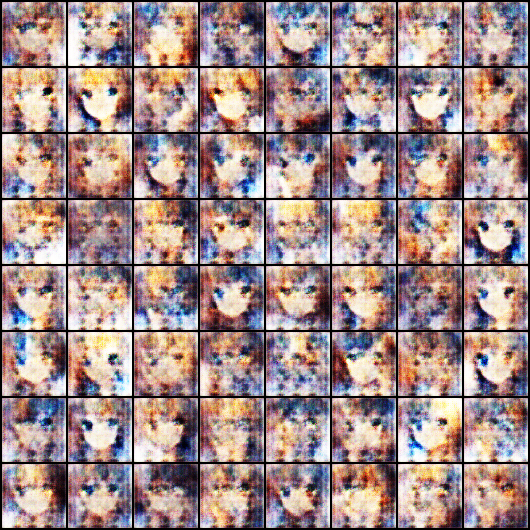

In [ ]:
from IPython.display import Image

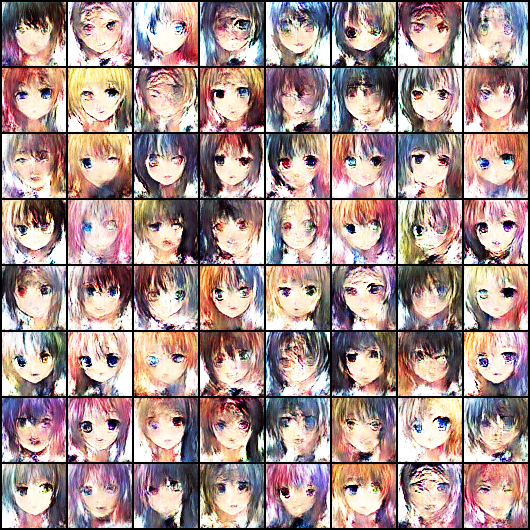

In [ ]:
Image('./generated/generated-images-0001.png')

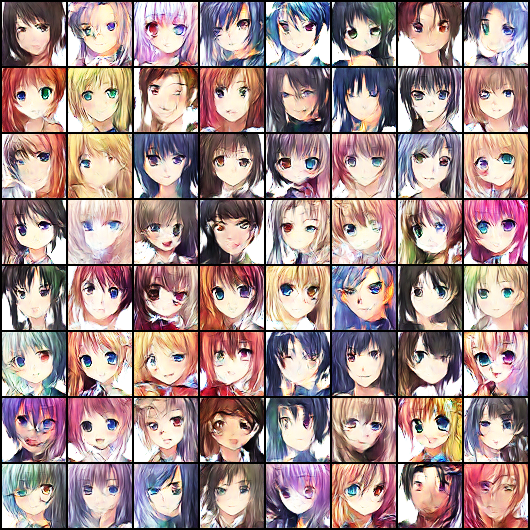

In [ ]:
Image('./generated/generated-images-0010.png')

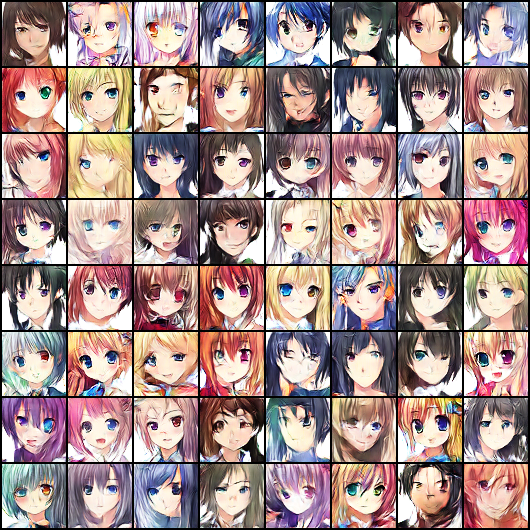

In [ ]:
Image('./generated/generated-images-0050.png')

Image('./generated/generated-images-0100.png')

In [ ]:
We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

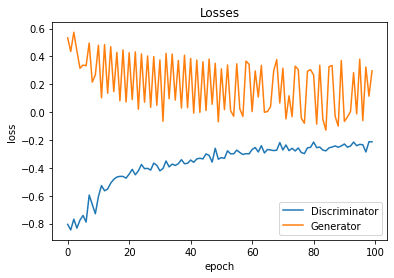

In [ ]:
Here's what it looks like:

![]()


We can also visualize how the loss changes over time. Visualizing 
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



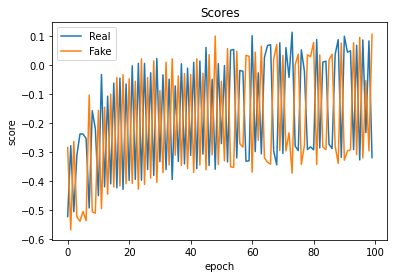

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');